<a href="https://www.kaggle.com/code/chinmaygope/diabetes-prediction-model?scriptVersionId=193635483" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-dataset/diabetes.csv


# **Importing the dependencies**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter(action='ignore')
sns.set()
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
#loading diabetes dataset to pandas dataframe
df = pd.read_csv('/kaggle/input/diabetes-dataset/diabetes.csv')
df.head()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.columns

# **Statistical Description**

In [ ]:
# independent features : Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
#       'BMI', 'DiabetesPedigreeFunction', 'Age'
# independent features : 'Outcome'
df.describe()

In [ ]:
df.shape

In [ ]:
df.Outcome.value_counts() * 100 / len(df)

# **Exploratory Data Analysis** 

In [ ]:
plt.figure(figsize=(8,7))
plt.xlabel('Age',fontsize=10)
plt.ylabel('Count',fontsize=10)
df.Age.hist(edgecolor='black')

In [ ]:
print("MAX AGE: "+str(df.Age.max()))
print("MIN AGE: "+str(df.Age.min()))

In [ ]:
df.columns

In [ ]:
def plot_histograms(df):
    fig, ax = plt.subplots(4, 2, figsize=(20, 20))
     # Define the features to plot
    features = ['Pregnancies', 'Glucose', 'BloodPressure', 
                'SkinThickness', 'Insulin', 'BMI', 
                'DiabetesPedigreeFunction', 'Age']
    
    # Plot histograms with KDE for each feature
    for i, feature in enumerate(features):
        sns.histplot(df[feature], bins=20, ax=ax[i//2, i%2], 
                     color='red', kde=True, edgecolor='black', stat='density')
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_histograms(df)

In [ ]:
df.columns

In [ ]:
df.groupby('Outcome').agg({'Pregnancies':'mean'})

In [ ]:
df.groupby('Outcome').agg({'Pregnancies':'max'})

In [ ]:
df.groupby('Outcome').agg({'Glucose':'mean'})

In [ ]:
df.groupby('Outcome').agg({'Glucose':'max'})

In [ ]:
df.groupby('Outcome').agg({'BloodPressure':'mean'})

In [ ]:
df.groupby('Outcome').agg({'BloodPressure':'max'})

In [ ]:
df.groupby('Outcome').agg({'SkinThickness':'mean'})

In [ ]:
df.groupby('Outcome').agg({'SkinThickness':'max'})

In [ ]:
df.groupby('Outcome').agg({'Insulin':'mean'})

In [ ]:
df.groupby('Outcome').agg({'Insulin':'max'})

In [ ]:
df.groupby('Outcome').agg({'DiabetesPedigreeFunction':'mean'})

In [ ]:
df.groupby('Outcome').agg({'DiabetesPedigreeFunction':'max'})

In [ ]:
df.groupby('Outcome').agg({'BMI':'mean'})

In [ ]:
df.groupby('Outcome').agg({'BMI':'max'})

In [ ]:
df.groupby('Outcome').agg({'Age':'mean'})

In [ ]:
df.groupby('Outcome').agg({'Age':'max'})

In [ ]:
def plot_all_attributes_stats(df,attr,color_mean):
    # Calculate mean and max for Pregnancies grouped by Outcome
    mean_attr = df.groupby('Outcome').agg({attr : 'mean'}).reset_index()
    max_attr = df.groupby('Outcome').agg({ attr: 'max'}).reset_index()

    # Merge the two dataframes on Outcome
    stats_df = pd.merge(mean_attr, max_attr, on='Outcome', suffixes=('_mean', '_max'))

    # Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = stats_df['Outcome']
    
   # Plotting mean values
    bars1 = plt.bar(index - bar_width/2, stats_df[f'{attr}_mean'], bar_width, 
                    label=f'Mean {attr}', color=color_mean)
    
    # Plotting max values
    bars2 = plt.bar(index + bar_width/2, stats_df[f'{attr}_max'], bar_width, 
                    label='Max Pregnancies', color='blue')
    
    # Annotating the bars with the respective values
    for bar in bars1:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.2f}', ha ='center', va ='bottom')
    
    for bar in bars2:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.2f}', ha ='center', va ='bottom')
    
    plt.xlabel('Outcome')
    plt.ylabel(f'{attr}')
    plt.title(f'Mean and Max {attr} by Outcome')
    plt.xticks(index, ['No Diabetes', 'Diabetes'])
    plt.legend()
    
    plt.show()

In [ ]:
def plot_all_attributes_stats(df, attrs, color_mean):
    num_attributes = len(attrs)
    num_rows = (num_attributes + 1) // 2  # Calculate the number of rows needed (2 per row)
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6 * num_rows))
    
    # Flatten axes array if there's only one row
    if num_rows == 1:
        axes = axes.reshape(1, 2)
    
    for i, attr in enumerate(attrs):
        # Calculate mean and max for the attribute grouped by Outcome
        mean_attr = df.groupby('Outcome').agg({attr: 'mean'}).reset_index()
        max_attr = df.groupby('Outcome').agg({attr: 'max'}).reset_index()

        # Merge the two dataframes on Outcome
        stats_df = pd.merge(mean_attr, max_attr, on='Outcome', suffixes=('_mean', '_max'))

        # Determine subplot location
        ax = axes[i // 2, i % 2]
        
        # Plotting mean values
        bars1 = ax.bar(stats_df['Outcome'] - 0.35 / 2, stats_df[f'{attr}_mean'], 0.35, 
                       label=f'Mean {attr}', color=color_mean)
        
        # Plotting max values
        bars2 = ax.bar(stats_df['Outcome'] + 0.35 / 2, stats_df[f'{attr}_max'], 0.35, 
                       label='Max ' + attr, color='blue')
        
        # Annotating the bars with the respective values
        for bar in bars1:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f'{bar.get_height():.2f}', ha='center', va='bottom')
        
        for bar in bars2:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f'{bar.get_height():.2f}', ha='center', va='bottom')
        
        ax.set_xlabel('Outcome')
        ax.set_ylabel(attr)
        ax.set_title(f'Mean and Max {attr} by Outcome')
        ax.set_xticks(stats_df['Outcome'])
        ax.set_xticklabels(['No Diabetes', 'Diabetes'])
        ax.legend()

    # Remove empty subplots if any
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1, -1])
    
    plt.tight_layout()
    plt.show()

In [ ]:
attribute =  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# plot_all_attributes_stats(df,attribute,color_mean='green')

In [ ]:
# call the function

# plot_all_attributes_stats(df, 'Pregnancies', color_mean='green')
# plot_all_attributes_stats(df, 'Glucose', color_mean='orange')
# plot_all_attributes_stats(df, 'BloodPressure', color_mean='grey')
# plot_all_attributes_stats(df, 'SkinThickness', color_mean='green')
# plot_all_attributes_stats(df, 'Insulin', color_mean='purple')
# plot_all_attributes_stats(df, 'BMI', color_mean='olive')
# plot_all_attributes_stats(df, 'DiabetesPedigreeFunction', color_mean='red')
# plot_all_attributes_stats(df, 'Age', color_mean='teal')

In [ ]:
# target - outcome column
f, ax = plt.subplots(1,2, figsize=(18,8))
df.Outcome.value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Target')
ax[0].set_ylabel('')
sns.countplot(x='Outcome', data=df, ax=ax[1])
ax[1].set_title('Outcome')
plt.show()

In [ ]:
df.corr()

In [ ]:
f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, fmt='.2f', ax=ax, cmap='Greens',square=True)
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()

# **Data Preprocessing**

In [ ]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0,np.NaN)


In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
import missingno as ms
ms.bar(df,color='orange')

In [ ]:
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp[[var,'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [ ]:
columns = df.columns
columns = columns.drop('Outcome')
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0) & (df[i].isnull()),i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1) & (df[i].isnull()),i] = median_target(i)[i][1]

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

# **Removing Outliers**

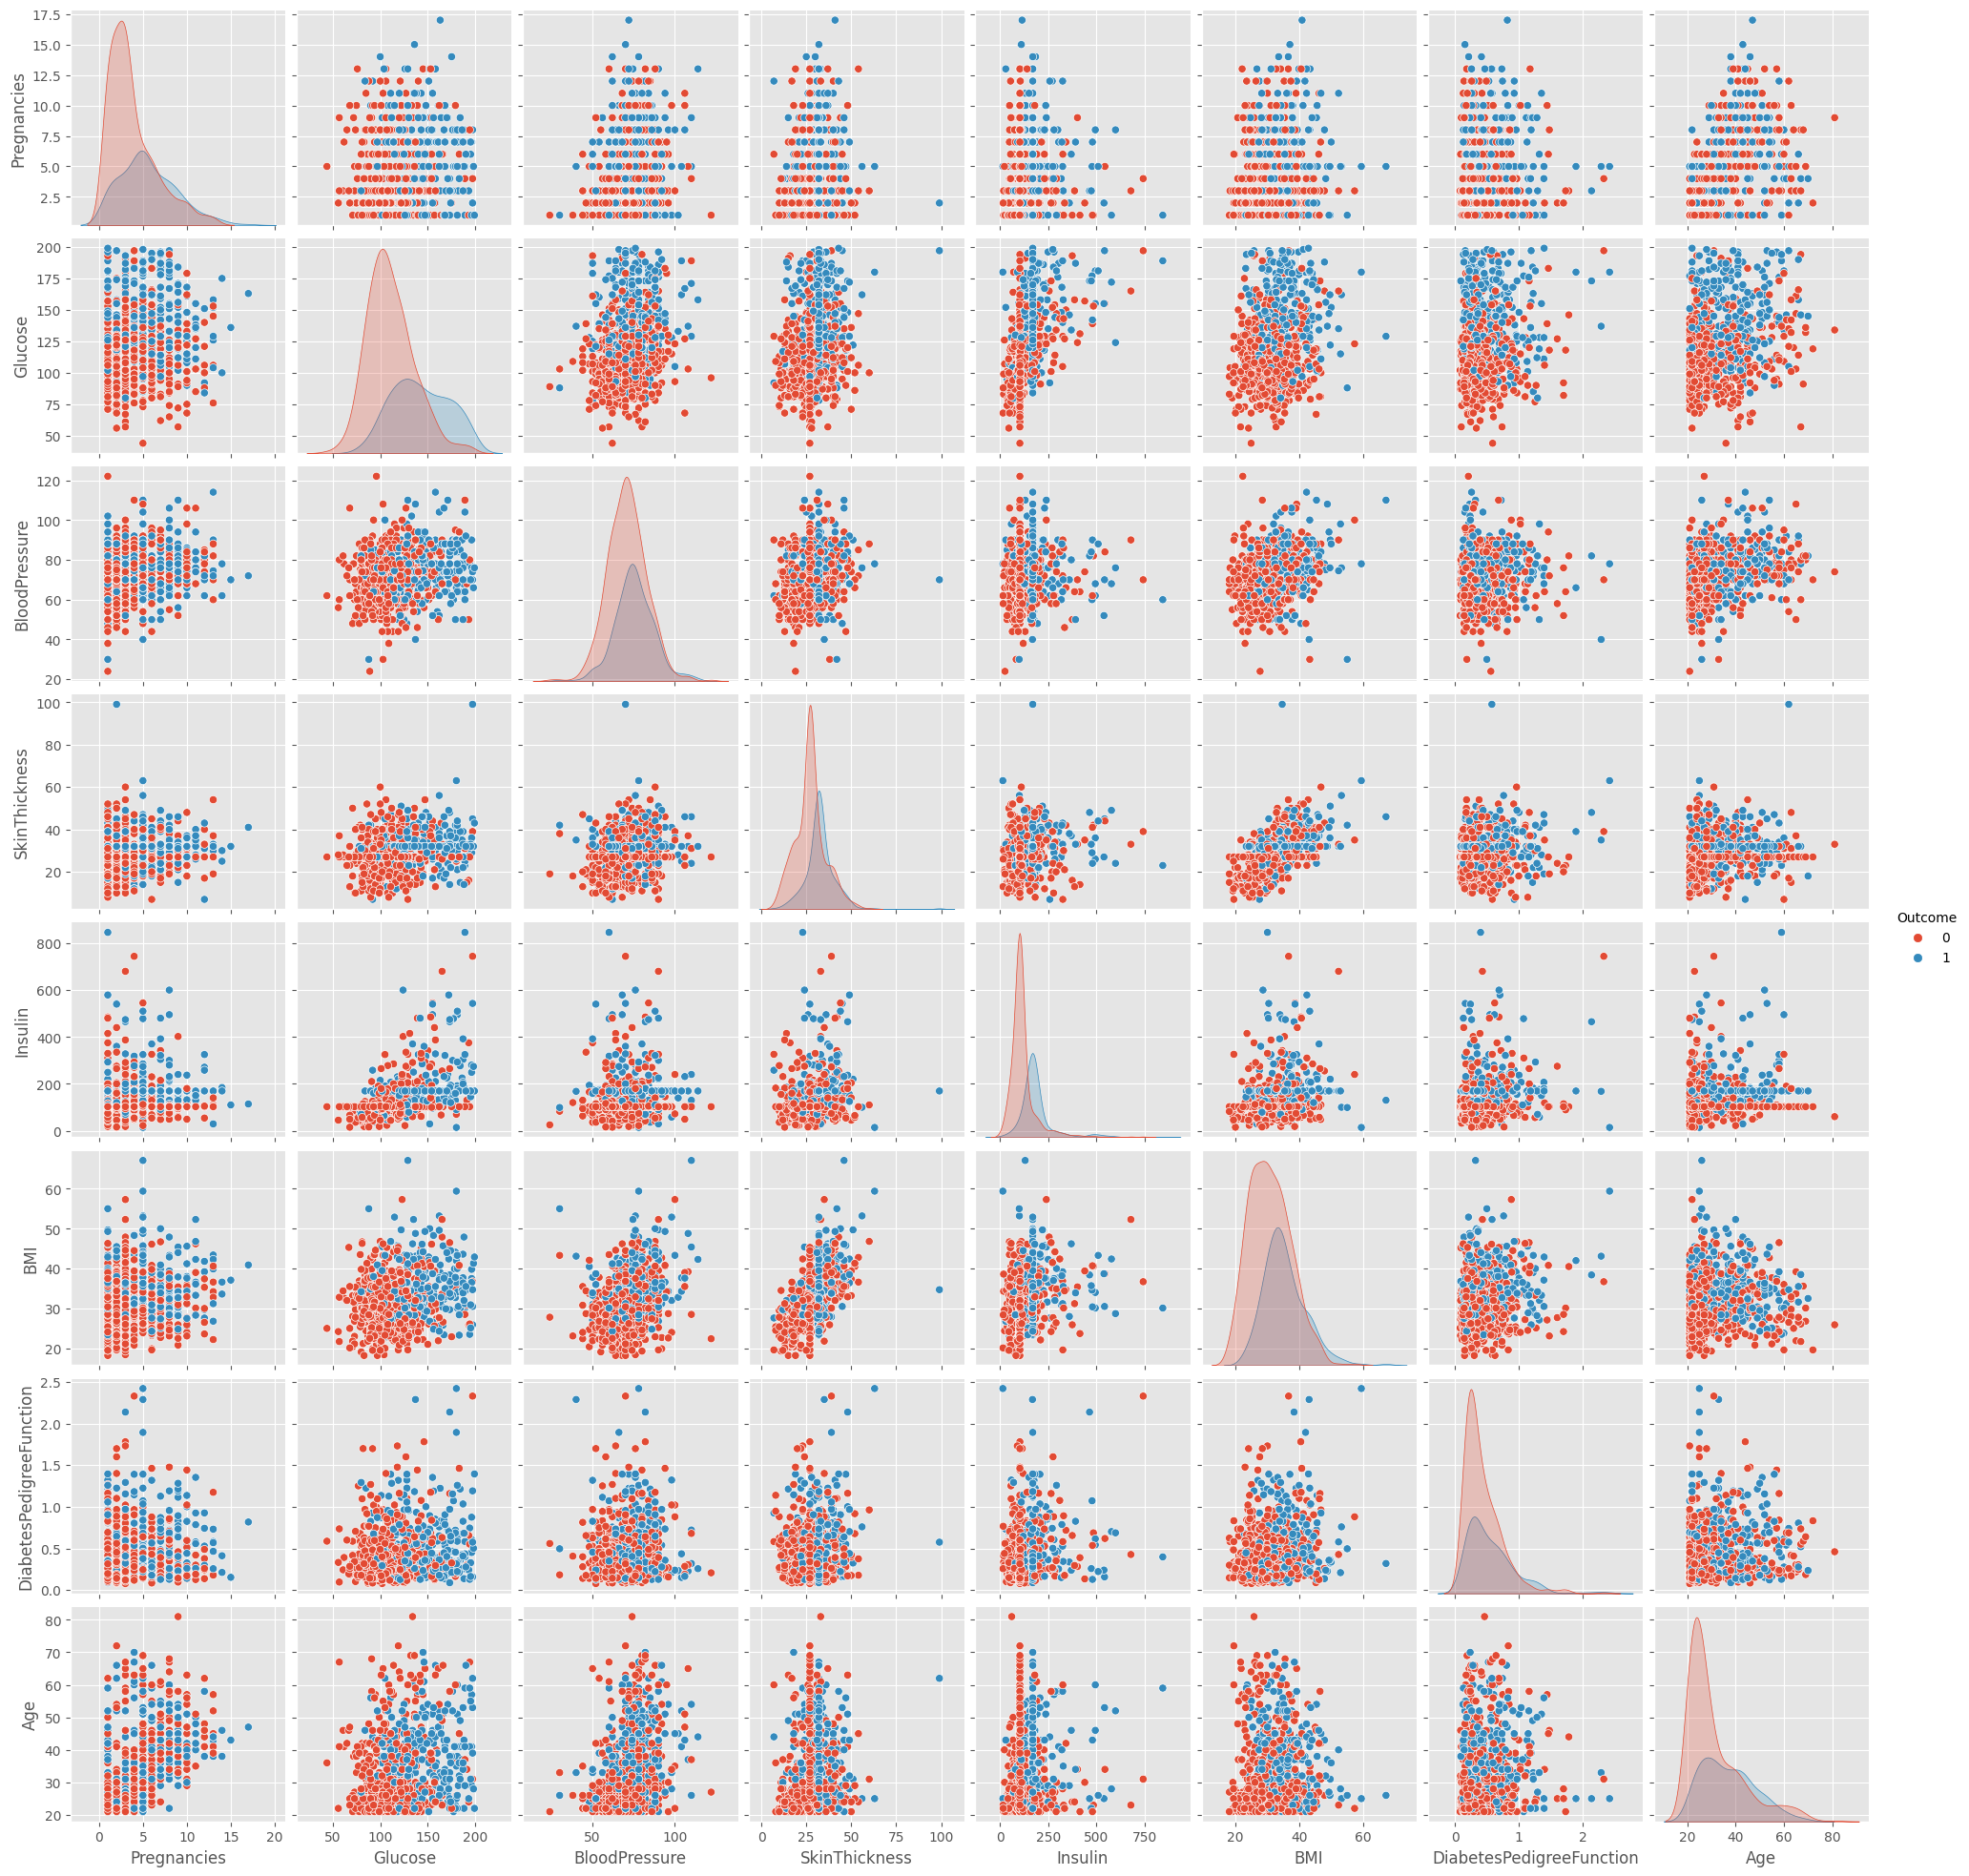

In [50]:
#pair plot
p = sns.pairplot(df,hue='Outcome')

In [51]:
#IQR Interquartile Range
for feature in df:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    print(feature,"YES") if df[(df[feature] > upper)].any(axis=None) else print(feature,"NO")        

Pregnancies YES
Glucose NO
BloodPressure YES
SkinThickness YES
Insulin YES
BMI YES
DiabetesPedigreeFunction YES
Age YES
Outcome NO


<Axes: xlabel='Insulin'>

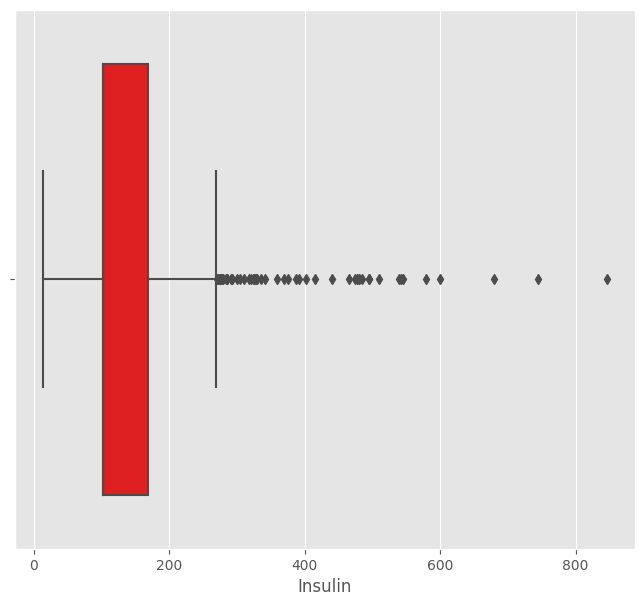

In [52]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Insulin,color='red')

In [53]:
Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)
df.loc[df.Insulin > upper,'Insulin'] = upper

<Axes: xlabel='Insulin'>

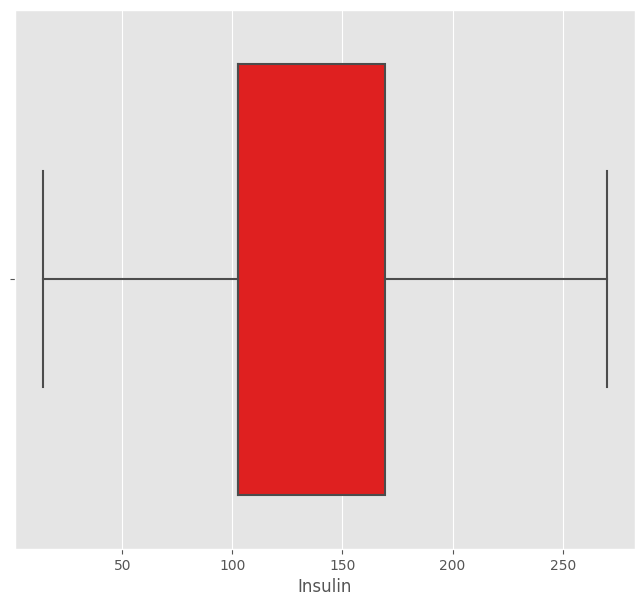

In [54]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Insulin,color='red')

In [55]:
#LOF local outlier factor

from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

In [56]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

<Axes: xlabel='Pregnancies'>

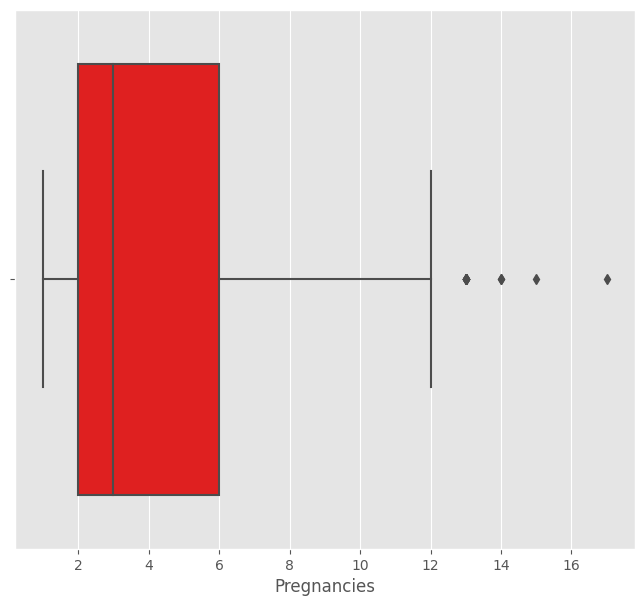

In [57]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Pregnancies,color='red')

<Axes: xlabel='BloodPressure'>

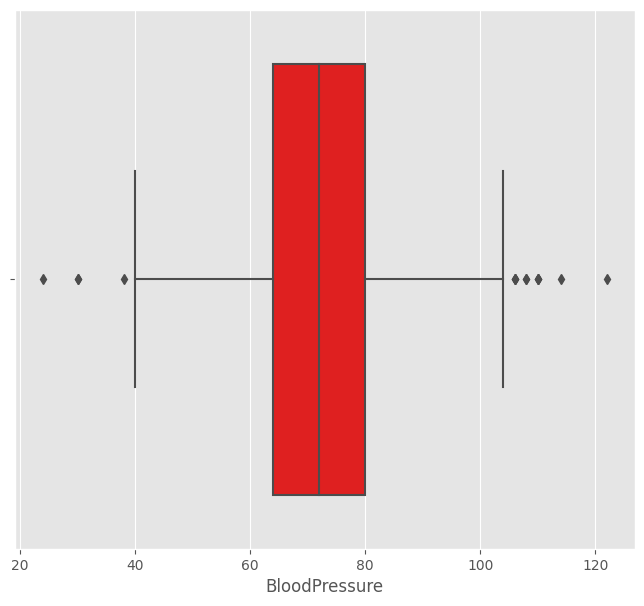

In [58]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.BloodPressure	,color='red')

<Axes: xlabel='BMI'>

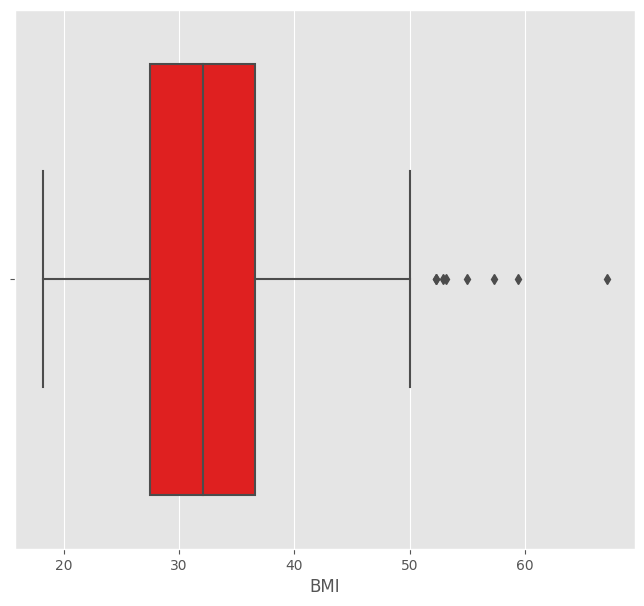

In [59]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.BMI,color='red')

<Axes: xlabel='DiabetesPedigreeFunction'>

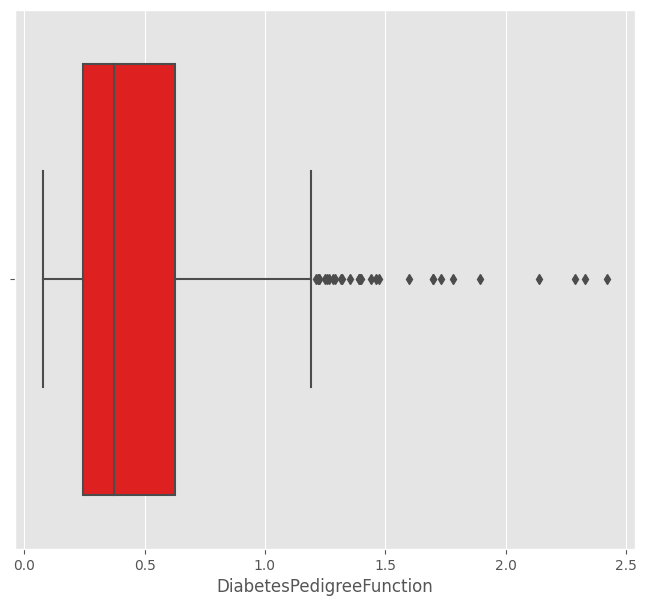

In [60]:

plt.figure(figsize=(8,7))
sns.boxplot(x= df.DiabetesPedigreeFunction,color='red')

<Axes: xlabel='Age'>

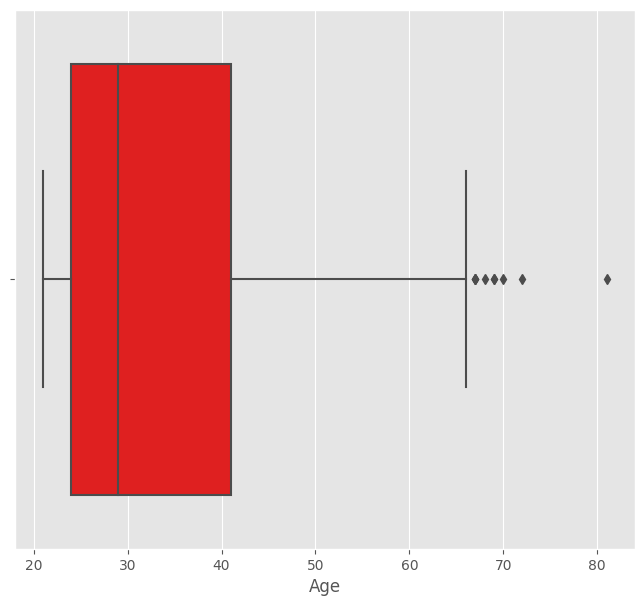

In [61]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Age,color='red')

<Axes: xlabel='Insulin'>

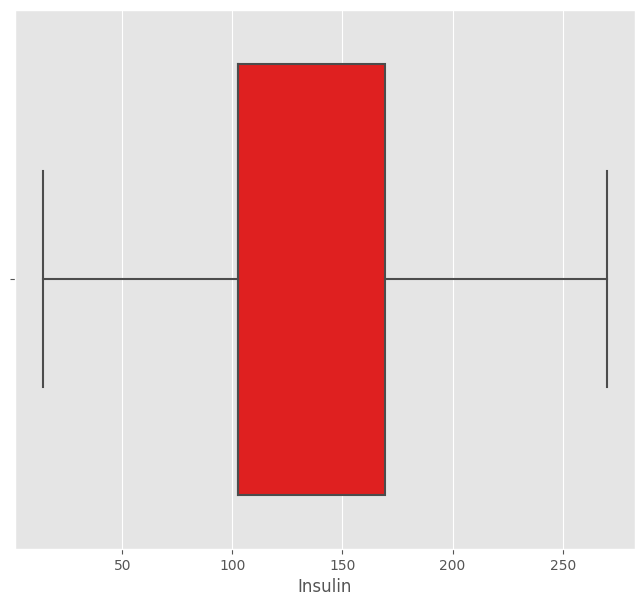

In [62]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Insulin,color='red')

In [63]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:20]

array([-3.06509976, -2.38250393, -2.15557018, -2.11501347, -2.08356175,
       -1.95386655, -1.83559384, -1.74974237, -1.7330214 , -1.71017168,
       -1.70215105, -1.68722889, -1.64294601, -1.64180205, -1.61181746,
       -1.61067772, -1.60925053, -1.60214364, -1.59998552, -1.58761193])

In [64]:
threshold = np.sort(df_scores)[7] # 7 values have outlayer

In [65]:
threshold

-1.7497423670960557

In [66]:
outlier = df_scores > threshold

In [67]:
df = df[outlier]

In [68]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [69]:
df.shape #now shape is 760 and not 768

(760, 9)

# **Feature Engineering**

In [70]:
BMI_Category = pd.Series(['Underweight', 'Normal', 'Overweight', 'Obesity 1', 'Obesity 2', 'Obesity 3'], dtype='category')

In [71]:
BMI_Category

0    Underweight
1         Normal
2     Overweight
3      Obesity 1
4      Obesity 2
5      Obesity 3
dtype: category
Categories (6, object): ['Normal', 'Obesity 1', 'Obesity 2', 'Obesity 3', 'Overweight', 'Underweight']

In [72]:
df.BMI_Category = BMI_Category
df.loc[df["BMI"]  < 18.5, "BMI_Category"] = BMI_Category[0]
df.loc[(df["BMI"] > 18.5) & df["BMI"]<=24.9, "BMI_Category"] = BMI_Category[1]
df.loc[(df["BMI"] > 24.9) & df["BMI"]<=29.9, "BMI_Category"] = BMI_Category[2]
df.loc[(df["BMI"] > 29.9) & df["BMI"]<=34.9, "BMI_Category"] = BMI_Category[3]
df.loc[(df["BMI"] > 34.9) & df["BMI"]<=39.9, "BMI_Category"] = BMI_Category[4]
df.loc[df["BMI"]  > 39.9, "BMI_Category"] = BMI_Category[5]

/tmp/ipykernel_33/2156945527.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.BMI_Category = BMI_Category
/tmp/ipykernel_33/2156945527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["BMI"]  < 18.5, "BMI_Category"] = BMI_Category[0]


In [73]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome BMI_Category  
0                     0.627   50        1    Obesity 2  
1                     0.351   31        0    Obesity 2  
2                     0.672   32        1    Obesity 2  
3                     0.167   21        0    Obesity 2  
4                     2.288   33        1    Obesity 3

In [ ]:
def set_insulin(row):
    return 'Normal' if row["Insulin"] >= 16 and row["Insulin"] <= 166 else 'Abnormal'

In [ ]:
df = df.assign(Insulin_Score = df.apply(set_insulin,axis=1))

In [ ]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome BMI_Category Insulin_Score  
0                     0.627   50        1    Obesity 2      Abnormal  
1                     0.351   31        0    Obesity 2        Normal  
2                     0.672   32        1    Obesity 2      Abnormal  
3                     0.167   21        0    Obesity 2        Normal  
4                     2.288   33        1    Obesity 3      Abnormal

In [ ]:
# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")
df["NewGlucose"] = NewGlucose
df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [ ]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome BMI_Category Insulin_Score  \
0                     0.627   50        1    Obesity 2      Abnormal   
1                     0.351   31        0    Obesity 2        Normal   
2                     0.672   32        1    Obesity 2      Abnormal   
3                     0.167   21        0    Obesity 2        Normal   
4                     2.288   33        1    Obesity 3      Abnormal   

  NewGlucose  
0     Secret  
1     Normal  
2     Secret  
3     Normal  
4     Secret

# **One Hot Encoding**

In [ ]:
 df = pd.get_dummies(df,columns=['BMI_Category','Insulin_Score','NewGlucose'],drop_first=True)

In [ ]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  BMI_Category_Obesity 3  \
0                     0.627   50        1                   False   
1                     0.351   31        0                   False   
2                     0.672   32        1                   False   
3                     0.167   21        0                   False   
4                     2.288   33        1                    True   

   Insulin_Score_Normal  NewGlucose_Low  NewGlucose_Normal  \
0                 False           False              False   
1                  True           False               True   
2                 False           False              False   
3                  True           False               True   
4                 False           False              False   

   NewGlucose_Overweight  NewGlucose_Secret  
0                  False               True  
1                  False              False  
2                  False               True  
3                  False              False  
4                  False               True

In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'BMI_Category_Obesity 3', 'Insulin_Score_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'],
      dtype='object')

In [ ]:
categorical_df = df[['BMI_Category_Obesity 3', 'Insulin_Score_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [ ]:
categorical_df.head()

BMI_Category_Obesity 3  Insulin_Score_Normal  NewGlucose_Low  \
0                   False                 False           False   
1                   False                  True           False   
2                   False                 False           False   
3                   False                  True           False   
4                    True                 False           False   

   NewGlucose_Normal  NewGlucose_Overweight  NewGlucose_Secret  
0              False                  False               True  
1               True                  False              False  
2              False                  False               True  
3               True                  False              False  
4              False                  False               True

In [ ]:
# Normalize boolean values to 1 and 0
categorical_df = categorical_df.astype(int)

In [ ]:
categorical_df.head()

BMI_Category_Obesity 3  Insulin_Score_Normal  NewGlucose_Low  \
0                       0                     0               0   
1                       0                     1               0   
2                       0                     0               0   
3                       0                     1               0   
4                       1                     0               0   

   NewGlucose_Normal  NewGlucose_Overweight  NewGlucose_Secret  
0                  0                      0                  1  
1                  1                      0                  0  
2                  0                      0                  1  
3                  1                      0                  0  
4                  0                      0                  1

In [ ]:
Y = df.Outcome
X =  df.drop(['BMI_Category_Obesity 3', 'Insulin_Score_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret','Outcome'],axis=1)

In [ ]:
cols = X.columns
index = X.index

In [ ]:
X.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33

In [ ]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns=cols, index=index)

In [ ]:
X.head() #range of (0 , -1)

Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0         0.75    0.775          0.000       1.000000  1.000000  0.177778   
1        -0.50   -0.800         -0.375       0.142857  0.000000 -0.600000   
2         1.25    1.650         -0.500       0.571429  1.000000 -0.966667   
3        -0.50   -0.700         -0.375      -0.714286 -0.126866 -0.433333   
4         0.50    0.500         -2.000       1.000000  0.977612  1.233333   

   DiabetesPedigreeFunction       Age  
0                  0.669707  1.235294  
1                 -0.049511  0.117647  
2                  0.786971  0.176471  
3                 -0.528990 -0.470588  
4                  4.998046  0.235294

In [ ]:
X = pd.concat([X,categorical_df],axis=1)

In [ ]:
X.head()

Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0         0.75    0.775          0.000       1.000000  1.000000  0.177778   
1        -0.50   -0.800         -0.375       0.142857  0.000000 -0.600000   
2         1.25    1.650         -0.500       0.571429  1.000000 -0.966667   
3        -0.50   -0.700         -0.375      -0.714286 -0.126866 -0.433333   
4         0.50    0.500         -2.000       1.000000  0.977612  1.233333   

   DiabetesPedigreeFunction       Age  BMI_Category_Obesity 3  \
0                  0.669707  1.235294                       0   
1                 -0.049511  0.117647                       0   
2                  0.786971  0.176471                       0   
3                 -0.528990 -0.470588                       0   
4                  4.998046  0.235294                       1   

   Insulin_Score_Normal  NewGlucose_Low  NewGlucose_Normal  \
0                     0               0                  0   
1                     1               0                  1   
2                     0               0                  0   
3                     1               0                  1   
4                     0               0                  0   

   NewGlucose_Overweight  NewGlucose_Secret  
0                      0                  1  
1                      0                  0  
2                      0                  1  
3                      0                  0  
4                      0                  1

# **Train Test Splitting**

In [ ]:
X_train,X_test ,Y_train,Y_test = train_test_split(X,Y, test_size=0.2,random_state=2)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# **Machine Learning Algorithms**

# **Logistic Regression**

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train,Y_train)

LogisticRegression()

In [ ]:
Y_pred = log_reg.predict(X_test)

In [ ]:
accuracy_score(Y_train, log_reg.predict(X_train))

0.8569078947368421

In [ ]:
Y_test

262    0
360    1
662    1
313    0
68     0
      ..
55     0
457    0
625    0
671    0
495    0
Name: Outcome, Length: 152, dtype: int64

In [ ]:
log_reg_acc =  accuracy_score(Y_test, log_reg.predict(X_test))
log_reg_acc 

0.875

In [ ]:
confusion_matrix(Y_test, Y_pred)

array([[92,  9],
       [10, 41]])

In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       101
           1       0.82      0.80      0.81        51

    accuracy                           0.88       152
   macro avg       0.86      0.86      0.86       152
weighted avg       0.87      0.88      0.87       152



# **KNN**

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
Y_pred= knn.predict(X_test)
print(accuracy_score(Y_train, knn.predict(X_train)))
knn_acc = accuracy_score(Y_test, knn.predict(X_test))
print(accuracy_score(Y_test, knn.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.8832236842105263
0.8486842105263158
[[93  8]
 [15 36]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       101
           1       0.82      0.71      0.76        51

    accuracy                           0.85       152
   macro avg       0.84      0.81      0.82       152
weighted avg       0.85      0.85      0.85       152



# **SVC**

In [ ]:
svc = SVC(probability=True)
param = {
    'gamma':[0.0001,0.001,0.01,0.1],
    'C':[0.1,0.05,0.01,1,10,15,20,1.5]
}
grid_search = GridSearchCV(svc,param)
grid_search.fit(X_train,Y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 0.05, 0.01, 1, 10, 15, 20, 1.5],
                         'gamma': [0.0001, 0.001, 0.01, 0.1]})

In [ ]:
grid_search.best_params_

{'C': 15, 'gamma': 0.01}

In [ ]:
grid_search.best_score_

0.8602086438152012

In [ ]:
svc = SVC(C=15,gamma=0.01,probability=True)
svc.fit(X_train,Y_train)
Y_pred= svc.predict(X_test)
print(accuracy_score(Y_train, svc.predict(X_train)))
svc_acc = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_score(Y_test, svc.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.875
0.8618421052631579
[[91 10]
 [11 40]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       101
           1       0.80      0.78      0.79        51

    accuracy                           0.86       152
   macro avg       0.85      0.84      0.84       152
weighted avg       0.86      0.86      0.86       152



# **Decision Tree**

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(X_train,Y_train)
Y_pred = DT.predict(X_test)
print(accuracy_score(Y_train, DT.predict(X_train)))
dt_acc = accuracy_score(Y_test, DT.predict(X_test))
print(accuracy_score(Y_test, DT.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

1.0
0.875
[[92  9]
 [10 41]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       101
           1       0.82      0.80      0.81        51

    accuracy                           0.88       152
   macro avg       0.86      0.86      0.86       152
weighted avg       0.87      0.88      0.87       152



In [ ]:
grid_param ={
    'criterion':['gini','entropy'],
    'max_depth':[3,5,7,10],
    'splitter':['random','best'],
    'min_samples_leaf':[1,2,3,4,5,6],
    'min_samples_split':[1,2,3,4,5,6],
    'max_features':['auto','sqrt','log2']
}
grid_search_dt = GridSearchCV(DT,grid_param, cv=50,n_jobs=-1,verbose=1)
grid_search_dt.fit(X_train,Y_train)

Fitting 50 folds for each of 1728 candidates, totalling 86400 fits


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/pytho

GridSearchCV(cv=50, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [1, 2, 3, 4, 5, 6],
                         'splitter': ['random', 'best']},
             verbose=1)

# **Hyperparameter Tuning**

In [ ]:
grid_search_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'splitter': 'best'}

In [ ]:
grid_search_dt.best_score_

0.8726923076923078

In [ ]:
DT = grid_search_dt.best_estimator_
Y_pred = DT.predict(X_test)
print(accuracy_score(Y_train, DT.predict(X_train)))
print(accuracy_score(Y_test, DT.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.899671052631579
0.875
[[95  6]
 [13 38]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       101
           1       0.86      0.75      0.80        51

    accuracy                           0.88       152
   macro avg       0.87      0.84      0.85       152
weighted avg       0.87      0.88      0.87       152



# **Random Forest Classifier**

In [ ]:
rand_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 7, max_features = 'log2', min_samples_leaf = 6, min_samples_split = 6, n_estimators = 150)

rand_clf.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       min_samples_leaf=6, min_samples_split=6,
                       n_estimators=150)

In [ ]:
grid_param ={
    'criterion':['gini','entropy'],
    'max_depth':[3,5,7,8,9,10],
    'splitter':['random','best'],
    'min_samples_leaf':[1,2,3,4,5,6,8,9,10],
    'min_samples_split':[1,2,3,4,5,6.8,9,10],
    'max_features':['auto','sqrt','log2'],
}
grid_search_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'splitter': 'best'}

In [ ]:
grid_search_dt.best_score_

0.8726923076923078

In [ ]:
Y_pred = rand_clf.predict(X_test)

In [ ]:
Y_pred = rand_clf.predict(X_test)
print(accuracy_score(Y_train, rand_clf.predict(X_train)))
rand_acc = accuracy_score(Y_test, rand_clf.predict(X_test))
print(accuracy_score(Y_test, rand_clf.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.930921052631579
0.9013157894736842
[[95  6]
 [ 9 42]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       101
           1       0.88      0.82      0.85        51

    accuracy                           0.90       152
   macro avg       0.89      0.88      0.89       152
weighted avg       0.90      0.90      0.90       152



# **Gradient Boosting Classifier**

In [ ]:
gbc = GradientBoostingClassifier()

parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200]
}

grid_search_gbc = GridSearchCV(gbc, parameters, cv = 10, n_jobs = -1, verbose = 1)
grid_search_gbc.fit(X_train, Y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1, 1, 10],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [100, 150, 180, 200]},
             verbose=1)

In [ ]:
grid_search_gbc.best_params_

{'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 200}

In [ ]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, loss = 'deviance', n_estimators = 200)
gbc.fit(X_train, Y_train)

GradientBoostingClassifier(loss='deviance', n_estimators=200)

In [ ]:
grid_search_gbc.best_score_

0.8947540983606557

In [ ]:
gbc = grid_search_gbc.best_estimator_
Y_pred = gbc.predict(X_test)
print(accuracy_score(Y_train, gbc.predict(X_train)))
gbc_acc = accuracy_score(Y_test, gbc.predict(X_test))
print(accuracy_score(Y_test, gbc.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

1.0
0.9144736842105263
[[96  5]
 [ 8 43]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       101
           1       0.90      0.84      0.87        51

    accuracy                           0.91       152
   macro avg       0.91      0.90      0.90       152
weighted avg       0.91      0.91      0.91       152



# **XGB Regressor**

In [ ]:
from xgboost import XGBClassifier 
xgb = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.01, max_depth = 10, n_estimators = 180)

xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
Y_pred = xgb.predict(X_test)
print(accuracy_score(Y_train, xgb.predict(X_train)))
xgb_acc = accuracy_score(Y_test, xgb.predict(X_test))
print(accuracy_score(Y_test, gbc.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.9802631578947368
0.9144736842105263
[[97  4]
 [10 41]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       101
           1       0.91      0.80      0.85        51

    accuracy                           0.91       152
   macro avg       0.91      0.88      0.89       152
weighted avg       0.91      0.91      0.91       152



# **Model Comparison**

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'KNN',
              'SVM', 
              'Decision Tree Classifier',
              'Random Forest Classifier',
              'Gradient Boosting Classifier',
              'XgBoost'],
    'Score': [100*round(log_reg_acc,4),
              100*round(knn_acc,4),
              100*round(svc_acc,4), 
              100*round(dt_acc,4),
              100*round(rand_acc,4), 
              100*round(gbc_acc,4),
              100*round(xgb_acc,4)]
})
models.sort_values(by = 'Score', ascending = False)

Model  Score
5  Gradient Boosting Classifier  91.45
6                       XgBoost  90.79
4      Random Forest Classifier  90.13
0           Logistic Regression  87.50
3      Decision Tree Classifier  87.50
2                           SVM  86.18
1                           KNN  84.87

In [ ]:
import pickle
model = rand_acc
pickle.dump(model, open("/kaggle/working/diabetes.pkl",'wb'))

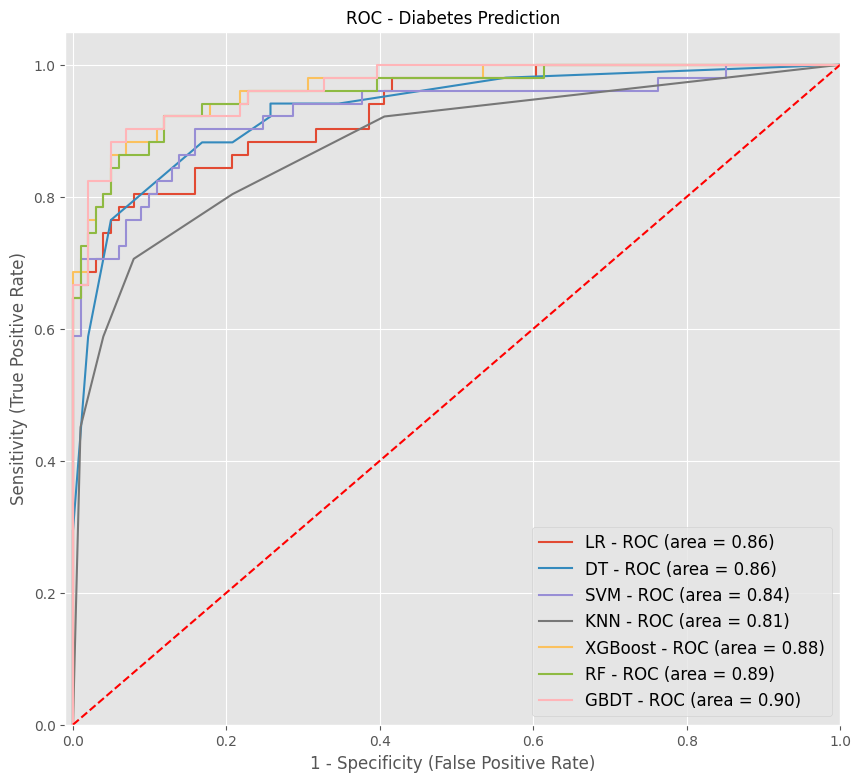

In [ ]:
from sklearn import metrics
plt.figure(figsize=(10,9))
models = [
{
    'label': 'LR',
    'model': log_reg,
},
{
    'label': 'DT',
    'model': DT,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]
for m in models:
    model = m['model'] 
    model.fit(X_train, Y_train) 
    Y_pred = model.predict(X_test) 
    fpr1, tpr1, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(Y_test,model.predict(X_test))
    plt.plot(fpr1, tpr1, label='%s - ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Diabetes Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("/kaggle/working/roc_diabetes.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# **Performance Evaluation** 

In [ ]:
print(f'mean_accuracies: {means_accuracy}')
print(f'mean_roc: {means_roc}')

NameError: name 'means_accuracy' is not defined

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'LR',
    'model': log_reg,
},
{
    'label': 'DT',
    'model': DT,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]

means_roc = []
means_accuracy = [100*round(log_reg_acc,4),
                  100*round(dt_acc,4),
                  100*round(svc_acc,4), 
                  100*round(knn_acc,4), 
                  100*round(xgb_acc,4), 
                  100*round(rand_acc,4), 
                  100*round(gbc_acc,4)]

for m in models:
    model = m['model'] 
    model.fit(X_train, Y_train) 
    Y_pred=model.predict(X_test) 
    fpr1, tpr1, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(Y_test,model.predict(X_test))
    auc = 100*round(auc,4)
    means_roc.append(auc)

# data to plot
n_groups = 7
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity,
color='mediumpurple',
label='Accuracy (%)')

rects2 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity,
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-1, 8])
plt.ylim([60, 95])

plt.title('Performance Evaluation - Diabetes Prediction', fontsize=18)
plt.xticks(index, ('LR', 'DT', 'SVM', 'KNN', 'XGBoost' , 'RF', 'GBDT'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.savefig("/kaggle/working/PE_diabetes.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()